In [451]:
#NOTE IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
import pandas as pd # Dataframe
import seaborn as sns # Boxplot

In [452]:
#NOTE CONSTANTS

AZIMUTH_MIN     = -180 # "under"-rotation
AZIMUTH_MAX     = 540 # with over-rotation
ELEVATION_MIN   = 15 # balcony ground collision at <=14°
ELEVATION_MAX   = 165 # flip-over
AZ_SPEED        = 1.6 # degrees per second, practically tested
EL_SPEED        = 1.6


waypoints = [
    #AZ     EL
    (0,     15), # parking position
    (350,   30),
    (180,   85),
    (0,     85),
    (90,    60),
    (10,    20),
    (270,   80),
    (45,    40),
    (165,   40),
]

In [453]:
#NOTE COORDINATE TRANSFORMATION

def azel_to_cartesian(az_deg: float, el_deg: float) -> np.ndarray:
    az = np.radians(az_deg)
    el = np.radians(el_deg)
    # standard unit spherical coordinates
    x = np.cos(el) * np.cos(az)
    y = np.cos(el) * np.sin(az)
    z = np.sin(el)
    return np.array([x, y, z])




def cartesian_to_azel(vec: np.ndarray) -> Tuple[float, float]:
    x, y, z = vec
    hyp = np.hypot(x, y) # hypotenuse = sqrt(x**2 + y**2)
    az = np.degrees(np.arctan2(y, x)) % 360 # full-circle azimuth
    el = np.degrees(np.arctan2(z, hyp))
    return az, el




def azel_to_polar(az_deg: float, el_deg: float) -> Tuple[float, float]:
    if el_deg > 90:
        el_deg = 180 - el_deg # flip over adjusting
    theta = np.radians(az_deg % 360)
    radius = 90 - el_deg # center = el_90
    return theta, radius

In [454]:
#NOTE SLERP

def slerp_path(start_az: float, start_el: float, end_az: float, end_el: float, steps: int = 1000) -> List[Tuple[float, float]]:
    # convert to 3D vectors
    p0 = azel_to_cartesian(start_az, start_el)
    p1 = azel_to_cartesian(end_az, end_el)

    # angle between start/end vector in radians
    # dot product of 2 unit vectors => cos(omega) (since theta will be used for polar)
    omega = np.arccos(np.clip(np.dot(p0, p1), -1.0, 1.0)) # ensure it stays between -1 and 1

    # small angles ~ linear anyway
    if np.isclose(omega, 0):
        return [(start_az, start_el)] * steps

    # otherwise calculate steps along the path
    sin_omega = np.sin(omega)
    path = []

    # formula: point(t) = [sin((1-t)*omega)*p0 + sin(t*omega)*p1]/sin(omega) -> sin() = weights
    # no weights -> cut through circle, like |x| + |y| + |z|
    # interpolate along spherical arc
    for t in np.linspace(0, 1, steps):
        factor0 = np.sin((1-t) * omega) / sin_omega
        factor1 = np.sin(t * omega) / sin_omega
        pt = factor0 * p0 + factor1 * p1
        az, el = cartesian_to_azel(pt) # reverse coordinate after calculation of path
        path.append((az, el))
    return path

In [455]:
#NOTE HELPER functions

# Gives angular difference in signed 180 range, thus showing direction [-180.0, 180.0]
def wrap180(az_diff):
    return (az_diff + 180.0) % 360.0 - 180.0




# Returns shortest rotation, positive -> clockwise, negative -> widdershins
def delta_shortest(az1, az2):
    return wrap180(az2 - az1)




# Calculates runtime for slewing telescope
def time_simult_upgraded(az_abs_diff: float, el_abs_diff: float) -> float:
    t_az = az_abs_diff / AZ_SPEED
    t_el = el_abs_diff / EL_SPEED
    return max(t_az, t_el)




# Constructs straight path for plotting
def straight_path(start: Tuple[float, float], az_diff: float, el_diff: float, steps: int = 500) -> Tuple[float, float]:
    az1, el1 = start
    t = np.linspace(0.0, 1.0, steps)
    az = az1 + az_diff * t
    el = el1 + el_diff * t
    return list(zip(az, el))




# Neither flip-over nor over/underrotate
def normal_path(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> dict:
    az1, el1 = start
    az2, el2 = end
    az_diff = delta_shortest(az1, az2)
    el_diff = el2 - el1
    return {
        "name": "no_flip_no_overr",
        "diffs": (az_diff, el_diff),
        "time": time_simult_upgraded(abs(az_diff), abs(el_diff)),
        "path": straight_path(start, az_diff, el_diff, steps)
    }




def overrotate(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> dict:
    az1, el1 = start
    az2, el2 = end
    az_diff = (az2 - az1) % 360.0
    el_diff = el2 - el1
    path = straight_path(start, az_diff, el_diff, steps)
    # Put coordinates back in 0-360
    path = [(az % 360.0, el) for az, el in path]
    return {
        "name": "overrotate",
        "diffs": (az_diff, el_diff),
        "time": time_simult_upgraded(abs(az_diff), abs(el_diff)),
        "path": path
    }




def underrotate(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> dict:
    az1, el1 = start
    az2, el2 = end
    delta = (az2 - az1) % 360.0
    az_diff = delta - 360.0
    el_diff = el2 - el1
    path = straight_path(start, az_diff, el_diff, steps)
    path = [(az % 360.0, el) for az, el in path]
    return {
        "name": "underrotate",
        "diffs": (az_diff, el_diff),
        "time": time_simult_upgraded(abs(az_diff), abs(el_diff)),
        "path": path
    }




def flip_over(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> dict:
    az1, el1 = start
    az2, el2 = end
    az_diff = az2 - az1 # not wrapped
    el_diff = el2 - el1
    path = straight_path(start, az_diff, el_diff, steps)
    path = [(az % 360.0, el) for az, el in path]
    return {
        "name": "flip-over",
        "diffs": (az_diff, el_diff),
        "time": time_simult_upgraded(abs(az_diff), abs(el_diff)),
        "path": path
    }


In [456]:
#NOTE SIMULTANEOUS PATH WITHOUT OVER/UNDERROTATION OR FLIP-OVER

def simultaneous_az_el_path(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> List[Tuple[float, float]]:
    az1, el1 = start
    az2, el2 = end

    az_vals = np.linspace(az1, az2, steps)
    el_vals = np.linspace(el1, el2, steps)

    az_vals = np.mod(az_vals, 360.0)

    return list(zip(az_vals, el_vals))

In [457]:
#NOTE MOVEMENT TIME CALCULATION

def movement_time(start: Tuple[float, float], end: Tuple[float, float]) -> float:
    # Extract coordinates
    az_start, el_start = start
    az_end, el_end = end

    # Shortest distances for AZ/EL
    delta_az = min(abs(az_end - az_start), 360 - abs(az_end - az_start))
    delta_el = abs(el_end - el_start)

    time_az = delta_az / AZ_SPEED
    time_el = delta_el / EL_SPEED

    return max(time_az, time_el) # Simultaneous AZ/EL movement


def slerp_path_time(path: List[Tuple[float, float]]) -> float:
    total_time = 0.0
    for i in range(1, len(path)):
        total_time += movement_time(path[i-1], path[i])
    return total_time

In [458]:
# NOTE UPGRADED LOGIC, SIMULT AZEL WITH OVER/UNDERROTATION AND FLIP-OVER

def choose_path_logic(start: Tuple[float, float],
                         end: Tuple[float, float],
                         steps: int = 500,
                         az_flip_thresh: float = 150.0,
                         el_flip_thresh: float = 70.0) -> dict:
    az1, el1 = start
    az2, el2 = end

    
    # Determine path baseline values
    az_diff_signed = delta_shortest(az1, az2)

    # Decide if flip-over is useful
    near_zenith = (el1 >= el_flip_thresh) or (el2 >= el_flip_thresh)
    big_az = abs(az_diff_signed) >= az_flip_thresh


    if near_zenith and big_az:
        return flip_over(start, end, steps)

    elif (az1 + az_diff_signed > 360.0) and (az1 + az_diff_signed <= 540.0):
        return overrotate(start, end, steps)

    elif (az1 + az_diff_signed < 0.0) and (az1 + az_diff_signed >= -180.0):
        return underrotate(start, end, steps)

    else:
        # Normal (constrained by limits) movement
        return normal_path(start, end, steps)




# Returns path only
def simult_azel_path_smart(start: Tuple[float, float],
                         end: Tuple[float, float],
                         steps: int = 500,
                         az_flip_thresh: float = 150.0,
                         el_flip_thresh: float = 70.0) -> dict:
    plan = choose_path_logic(start, end, steps, az_flip_thresh, el_flip_thresh)
    return plan["path"]




# Runs code
def compare_method(wps: List[Tuple[float, float]], steps: int = 500) -> pd.DataFrame:
    rows = []
    for i in range(len(wps) - 1):
        start, end = wps[i], wps[i+1]
        
        path_basic = simultaneous_az_el_path(start, end, steps=steps)
        time_basic = slerp_path_time(path_basic)
        rows.append({"From": start, "To": end, "Method": "AZ+EL Simult.", "Time (s)": time_basic})

        path_upgraded = simult_azel_path_smart(start, end, steps=steps)
        time_upgraded = slerp_path_time(path_upgraded)
        rows.append({"From": start, "To": end, "Method": "AZ+EL Upgraded", "Time (s)": time_upgraded})

        
        path_slerp = slerp_path(*start, *end, steps=500)
        time_slerp = slerp_path_time(path_slerp)
        rows.append({"From": start, "To": end, "Method": "SLERP", "Time (s)": time_slerp})

    df = pd.DataFrame(rows)
    # Rounding
    df["From"] = df["From"].apply(lambda t: (round(t[0], 1), round(t[1], 1)))
    df["To"] = df["To"].apply(lambda t: (round(t[0], 1), round(t[1], 1)))

    return df

In [459]:
#NOTE MAIN, COLLECTS ALL PATHS

def calc_paths(waypoints=waypoints):
    all_paths = []
    for i in range(len(waypoints) -1): 
        start = waypoints[i]
        end = waypoints[i + 1]

        # SLERP path and time
        path_slerp = slerp_path(*start, *end, steps=500)
        time_slerp = slerp_path_time(path_slerp)
        all_paths.append({
            "From": start,
            "To": end,
            "Path Type": "SLERP",
            "Time (s)": round(time_slerp, 2),
            "Path": path_slerp
            })

        # Simultaneous AZ+EL path
        path_simult = simultaneous_az_el_path(start, end, steps=500)
        time_simult = slerp_path_time(path_simult)
        all_paths.append({
            "From": start,
            "To": end,
            "Path Type": "AZ+EL Simult",
            "Time (s)": round(time_simult, 2),
            "Path": path_simult
        })

        # Upgraded
        plan = choose_path_logic(start, end, steps=500)
        all_paths.append({
            "From": start,
            "To": end,
            "Path Type": "AZ+EL Upgraded",
            "Time (s)": round(plan["time"], 2),
            "Path": plan["path"]
        })
    return all_paths

all_paths = calc_paths()

In [460]:
#NOTE DATAFRAME CONVERSION

def dataframe_conv(all_paths = all_paths):
    df = pd.DataFrame(all_paths)
    df["From"] = df["From"].apply(lambda t: (round(t[0], 1), round(t[1], 1)))
    df["To"] = df["To"].apply(lambda t: (round(t[0], 1), round(t[1], 1)))

    #print(df[["From", "To", "Path Type", "Time (s)"]].to_string(index=False))

    # Statistics
    # Group by coordinate pair -> select time column -> find index (row number) with minimum time -> loc selects actual rows after they are found
    fastest_per_segment = df.loc[df.groupby(["From", "To"])["Time (s)"].idxmin()]
    print(f"\nFastest per segment:\n{fastest_per_segment[["From", "To", "Path Type", "Time (s)"]]}")

    # Best
    win_counts = fastest_per_segment["Path Type"].value_counts()
    print(f"\nWin counts by {win_counts}")

    # Average Time per path type
    avg_times = df.groupby("Path Type")["Time (s)"].mean().sort_values()
    print(f"\nAverage Times:\n{avg_times}")
    return df

df = dataframe_conv()


Fastest per segment:
         From         To       Path Type  Time (s)
0     (0, 15)  (350, 30)           SLERP      9.37
10    (0, 85)   (90, 60)    AZ+EL Simult     56.25
17   (10, 20)  (270, 80)  AZ+EL Upgraded     62.50
21   (45, 40)  (165, 40)           SLERP     75.00
13   (90, 60)   (10, 20)    AZ+EL Simult     50.00
7   (180, 85)    (0, 85)    AZ+EL Simult    112.50
20  (270, 80)   (45, 40)  AZ+EL Upgraded     84.38
4   (350, 30)  (180, 85)    AZ+EL Simult    106.25

Win counts by Path Type
AZ+EL Simult      4
SLERP             2
AZ+EL Upgraded    2
Name: count, dtype: int64

Average Times:
Path Type
AZ+EL Upgraded     69.53250
SLERP              78.10000
AZ+EL Simult      115.23375
Name: Time (s), dtype: float64


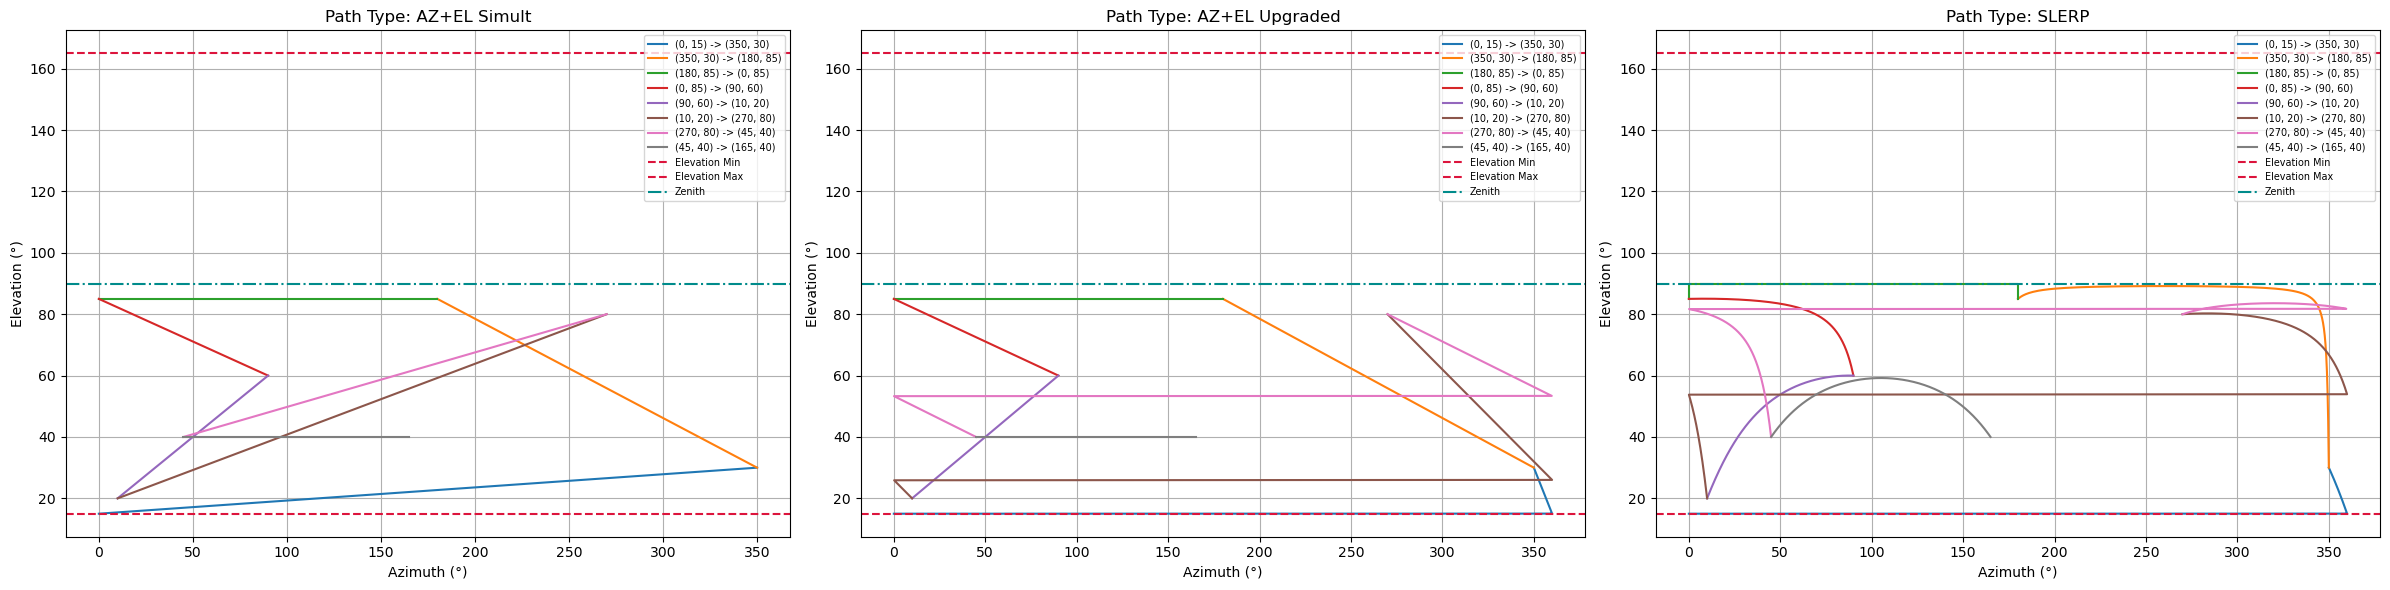

In [461]:
#NOTE 2D-AZEL-PROJECTED PLOT

path_types = sorted(set(entry["Path Type"] for entry in all_paths))

rows = 1
cols = int(np.ceil(len(path_types)))
fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 6 * rows), subplot_kw={"polar": False})
axes = axes.flat


for ax, path_type in zip(axes, path_types):
    for i, entry in enumerate(all_paths):
        if entry["Path Type"] == path_type:
            path = entry["Path"]
            az_list, el_list = zip(*path)
            az_list = [a % 360.0 for a in az_list]
            ax.plot(az_list, el_list, label=f"{entry['From']} -> {entry['To']}")

    ax.set_title(f"Path Type: {path_type}")
    ax.set_xlabel("Azimuth (°)")
    ax.set_ylabel("Elevation (°)")
    ax.axhline(y=ELEVATION_MIN, color="crimson", linestyle="--", label="Elevation Min")
    ax.axhline(y=ELEVATION_MAX, color="crimson", linestyle="--", label="Elevation Max")
    ax.axhline(y=90, color="darkcyan", linestyle="-.", label="Zenith")
    ax.grid(True)
    ax.legend(fontsize="x-small")

plt.tight_layout()
plt.show()

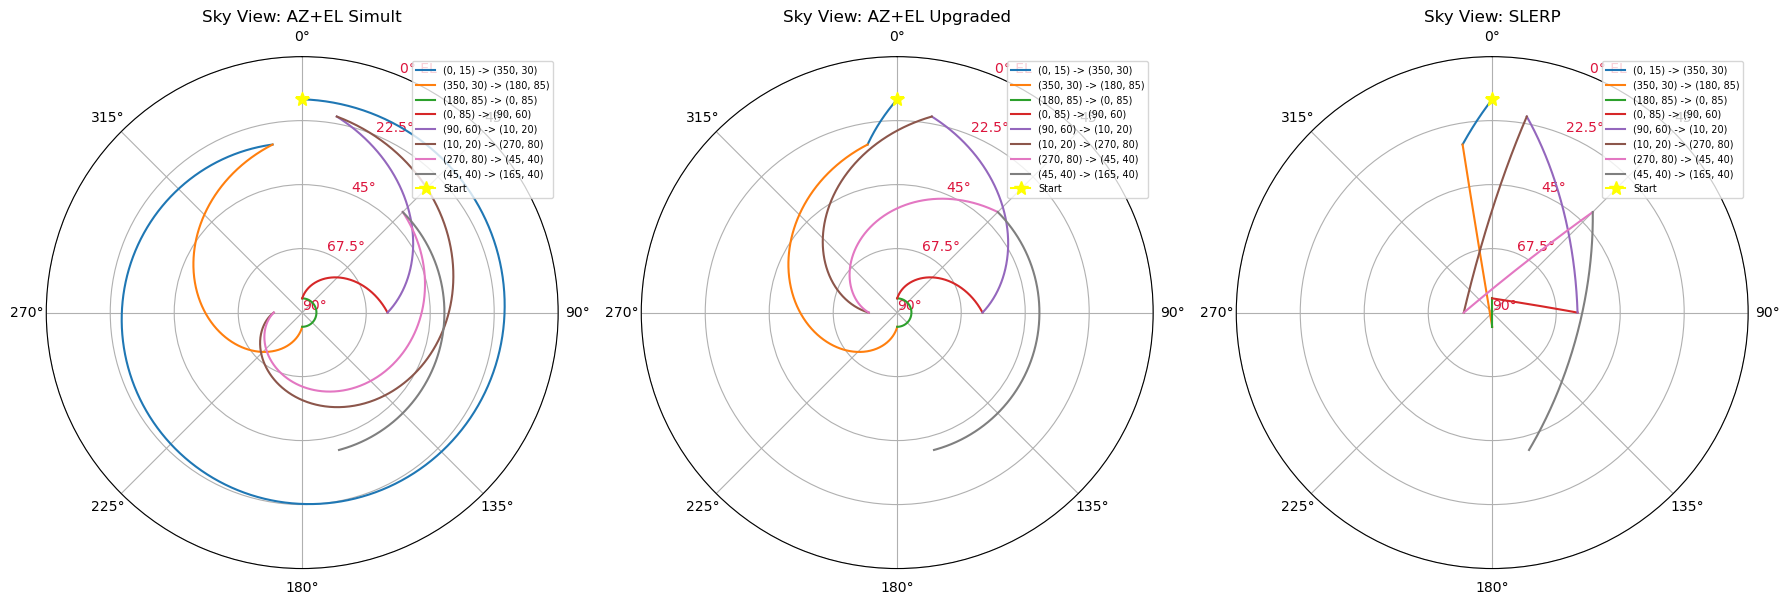

In [462]:
#NOTE POLAR-PROJECTED PLOTS

def polar_proj(all_paths=all_paths, legend=True):
    rows = 1
    cols = int(np.ceil(len(path_types)))
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows), subplot_kw={"polar": True})
    axes = axes.flat

    for ax, path_type in zip(axes, path_types):
        for i, entry in enumerate(all_paths):
            if entry["Path Type"] == path_type:
                path = entry["Path"]
                theta_and_r = [azel_to_polar(az, el) for az, el in path]
                theta, r = zip(*theta_and_r)
                from_coord = tuple(round(x, 2) for x in entry["From"])
                to_coord = tuple(round(y, 2) for y in entry["To"])
                ax.plot(theta, r, label=f"{from_coord} -> {to_coord}")

        # Starting point
        theta0, r0 = azel_to_polar(*waypoints[0])
        ax.plot([theta0], [r0], marker="*", markersize=10, color="yellow", label="Start")

        # Subplot formatting
        ax.set_title(f"Sky View: {path_type}")
        ax.set_ylim(0, 75)
        ax.set_yticks([0, 22.5, 45, 67.5, 90])
        ax.set_yticklabels(["90°", "67.5°", "45°", "22.5°", "0° EL"])
        for label in ax.get_yticklabels():
            label.set_color("crimson")
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        ax.grid(True)
        if legend:
            ax.legend(loc="upper right", fontsize="x-small")

    plt.tight_layout()
    plt.show()
    return

polar_proj()

In [463]:
#NOTE WAYPOINT GENERATOR + CALCULATING TIME FOR EACH WAYPOINT

def random_waypoints(n: int = 10) -> List[Tuple[float, float]]:
    az = np.random.uniform(0, 360, n)
    el = np.random.uniform(ELEVATION_MIN, 90.0, n)

    return list(zip(az, el))


def benchmark_segment(wps: List[Tuple[float, float]]):
    method_times = {
        "SLERP": [],
        "AZ+EL Simult": []
        }

    # Waypoint pairs for moving
    for i in range(len(wps) - 1):
        s, e = wps[i], wps[i + 1]

        method_times["SLERP"].append(slerp_path_time(slerp_path(*s, *e, steps=100)))

        sim_path = simultaneous_az_el_path(s, e, steps=100)
        method_times["AZ+EL Simult"].append(slerp_path_time(sim_path))

    return method_times

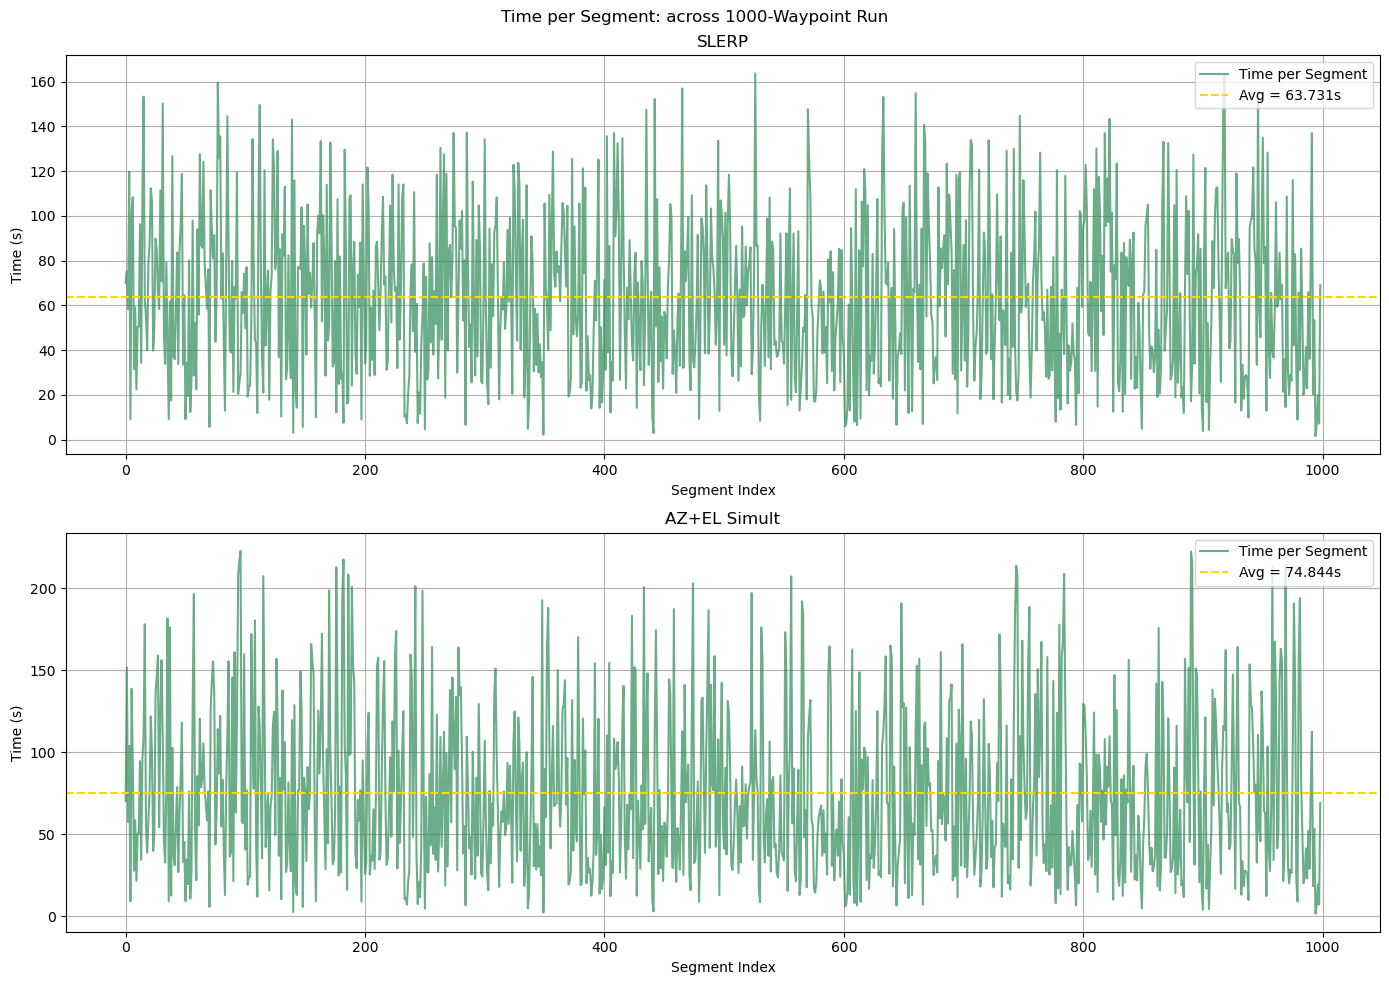

In [464]:
#NOTE PLOT LONG TERM BEHAVIOUR

def plot_time_per_segment(method_times: dict, n: int=10):
    fig, axs = plt.subplots(2, 1, figsize=(14, 10))
    axs = axs.flatten()

    for i, (method, times) in enumerate(method_times.items()):
        ax = axs[i]
        x = np.arange(len(times))
        y = np.array(times)

        ax.plot(x, y, label="Time per Segment", alpha=0.7, color="seagreen")
        ax.axhline(np.mean(y), color="gold", linestyle="--", label=f"Avg = {np.mean(y):.3f}s")

        ax.set_title(method)
        ax.set_ylabel("Time (s)")
        ax.set_xlabel("Segment Index")
        ax.grid(True)
        ax.legend()

    plt.suptitle(f"Time per Segment: across {n}-Waypoint Run")
    plt.tight_layout()
    plt.show()

N = 1000 # ADJUST HERE
wps = random_waypoints(N)
segment_times = benchmark_segment(wps)
plot_time_per_segment(segment_times, N)

In [465]:
#NOTE AVG DIFFS BETWEEN AXES

def average_delta(wps):
    total_az = 0
    total_el = 0
    for i in range(len(wps) - 1):
        az1, el1 = wps[i]
        az2, el2 = wps[i + 1]
        delta_az = min(abs(az2 - az1), 360 - abs(az2 - az1))
        delta_el = abs(el2 - el1)
        total_az += delta_az
        total_el += delta_el
    return total_az / (len(wps) - 1), total_el / (len(wps) - 1)

print("fixed  avg deltas", average_delta(waypoints))
print("random avg deltas", average_delta(wps))

fixed  avg deltas (110.625, 29.375)
random avg deltas (88.77568213228838, 25.992020270175647)


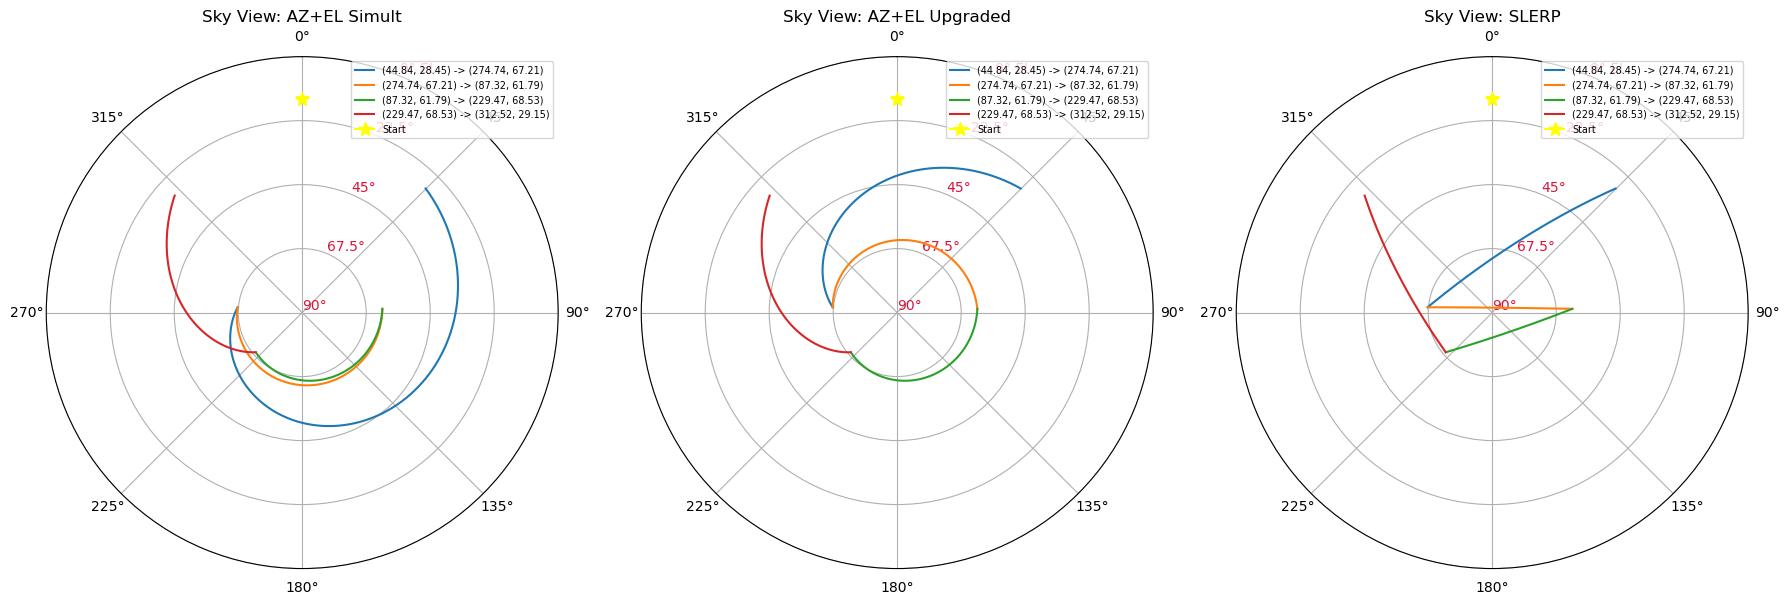

In [466]:
#NOTE PATH SHOWCASE OF RANDOM WPTS

wpts = random_waypoints(n=5)

all_paths2 = calc_paths(waypoints=wpts)

polar_proj(all_paths=all_paths2)


Fastest per segment:
               From             To       Path Type  Time (s)
875     (0.0, 23.0)  (267.3, 74.8)  AZ+EL Upgraded     57.94
438     (0.2, 32.9)   (43.3, 22.9)           SLERP     26.92
1724    (0.7, 53.7)  (236.1, 63.2)  AZ+EL Upgraded     77.89
2491    (0.9, 88.8)   (60.6, 36.6)    AZ+EL Simult     37.37
2401    (1.7, 45.3)  (151.4, 23.4)    AZ+EL Simult     93.56
...             ...            ...             ...       ...
1120  (359.1, 87.9)  (259.0, 33.0)    AZ+EL Simult     62.53
120   (359.2, 41.6)   (35.2, 30.7)           SLERP     22.54
1030  (359.5, 28.6)  (314.6, 67.9)    AZ+EL Simult     28.03
208   (359.7, 79.4)  (290.1, 50.0)    AZ+EL Simult     43.52
2239  (359.8, 33.0)  (241.9, 83.3)    AZ+EL Simult     73.74

[999 rows x 4 columns]

Win counts by Path Type
AZ+EL Simult      473
SLERP             361
AZ+EL Upgraded    165
Name: count, dtype: int64

Average Times:
Path Type
AZ+EL Upgraded    59.067237
SLERP             64.806977
AZ+EL Simult      76.90

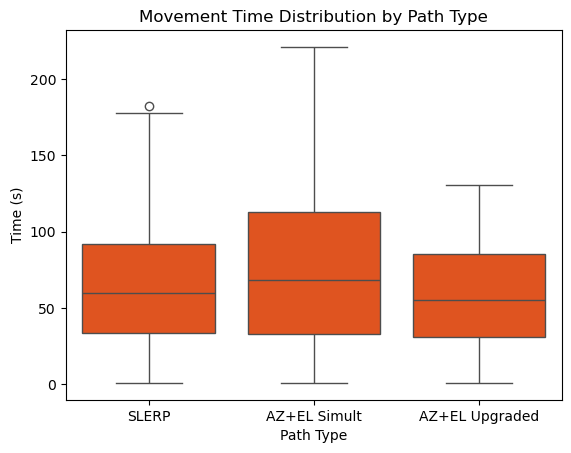

In [467]:
wpts = random_waypoints(n=1000)

all_paths3 = calc_paths(waypoints=wpts)

df3 = dataframe_conv(all_paths=all_paths3)

sns.boxplot(data=df3, x="Path Type", y="Time (s)", color="orangered")
plt.title("Movement Time Distribution by Path Type")
plt.show()


Fastest per segment (sample):
             From             To          Method    Time (s)       Source
1         (0, 15)      (350, 30)  AZ+EL Upgraded    9.375000      Determ.
9         (0, 85)       (90, 60)   AZ+EL Simult.   56.250000      Determ.
1066  (0.3, 48.3)  (303.0, 30.5)  AZ+EL Upgraded   35.809737  Random 1000
2509  (0.7, 33.8)  (224.6, 16.6)  AZ+EL Upgraded   85.086020  Random 1000
91    (0.7, 42.5)  (191.5, 17.5)  AZ+EL Upgraded  105.763649  Random 1000
1957  (1.2, 40.7)  (268.2, 36.7)  AZ+EL Upgraded   58.135986  Random 1000
783   (1.5, 72.9)  (152.8, 43.1)   AZ+EL Simult.   94.528508  Random 1000
2569  (2.3, 59.5)  (148.4, 19.0)  AZ+EL Upgraded   91.275091  Random 1000
1769  (2.9, 75.1)   (91.7, 80.1)           SLERP   55.500857  Random 1000
865   (2.9, 88.3)  (320.7, 76.4)  AZ+EL Upgraded   26.359426  Random 1000

Win counts by method:
        Source          Method  Wins
0      Determ.   AZ+EL Simult.     3
1      Determ.  AZ+EL Upgraded     5
2  Random 1000   AZ+E

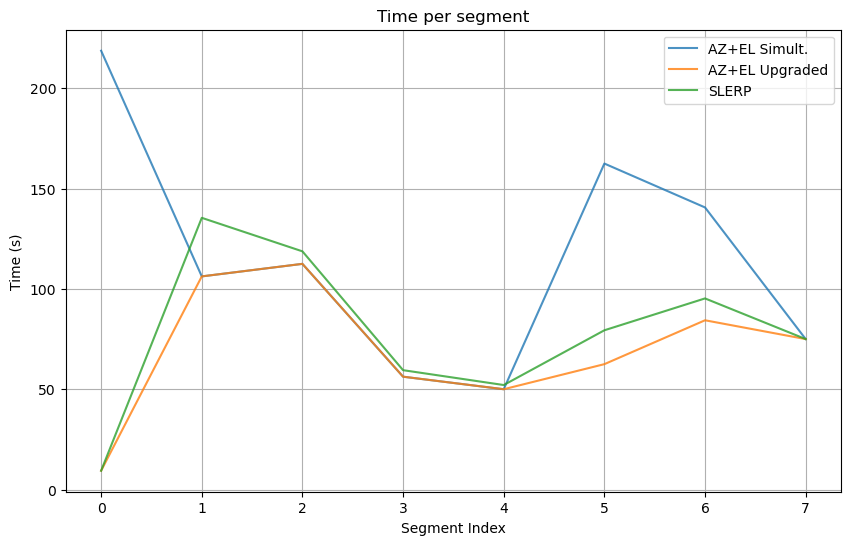

In [468]:
#NOTE PLOT and Statistics

df_predet = compare_method(waypoints, steps=500)

N = 1000
wps = random_waypoints(N)
df_rand = compare_method(wps, steps=500)

df_all = pd.concat([df_predet.assign(Source="Determ."),
                    df_rand.assign(Source=f"Random {N}")],
                    ignore_index=True)




fastest = df_all.loc[df_all.groupby(["From", "To", "Source"])["Time (s)"].idxmin()]
win_counts = fastest.groupby(["Source", "Method"]).size().reset_index(name="Wins")
avg_times =df_all.groupby(["Source", "Method"])["Time (s)"].mean().reset_index()

print("\nFastest per segment (sample):")
print(fastest.head(10))

print("\nWin counts by method:")
print(win_counts)

print("\nAverage time by method:")
print(avg_times)




# Line plot to show difference between basic and upgraded logic
plt.figure(figsize=(10, 6))
for method in df_predet["Method"].unique():
    y = df_predet[df_predet["Method"] == method]["Time (s)"].to_numpy()
    x = np.arange(len(y))
    plt.plot(x, y, label=method, alpha=0.8)
plt.title("Time per segment")
plt.xlabel("Segment Index")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()
plt.show()

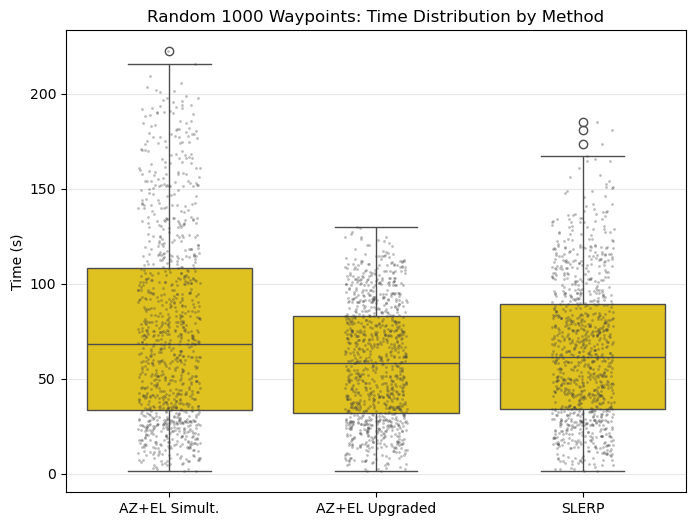

In [469]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=df_rand, x="Method", y="Time (s)", color="gold")
sns.stripplot(data=df_rand, x="Method", y="Time (s)", alpha=0.35, jitter=0.15, size=2, color=".25")
ax.set_title(f"Random {N} Waypoints: Time Distribution by Method")
ax.set_xlabel("")
ax.set_ylabel("Time (s)")
ax.grid(True, axis="y", alpha=0.3)
plt.show()

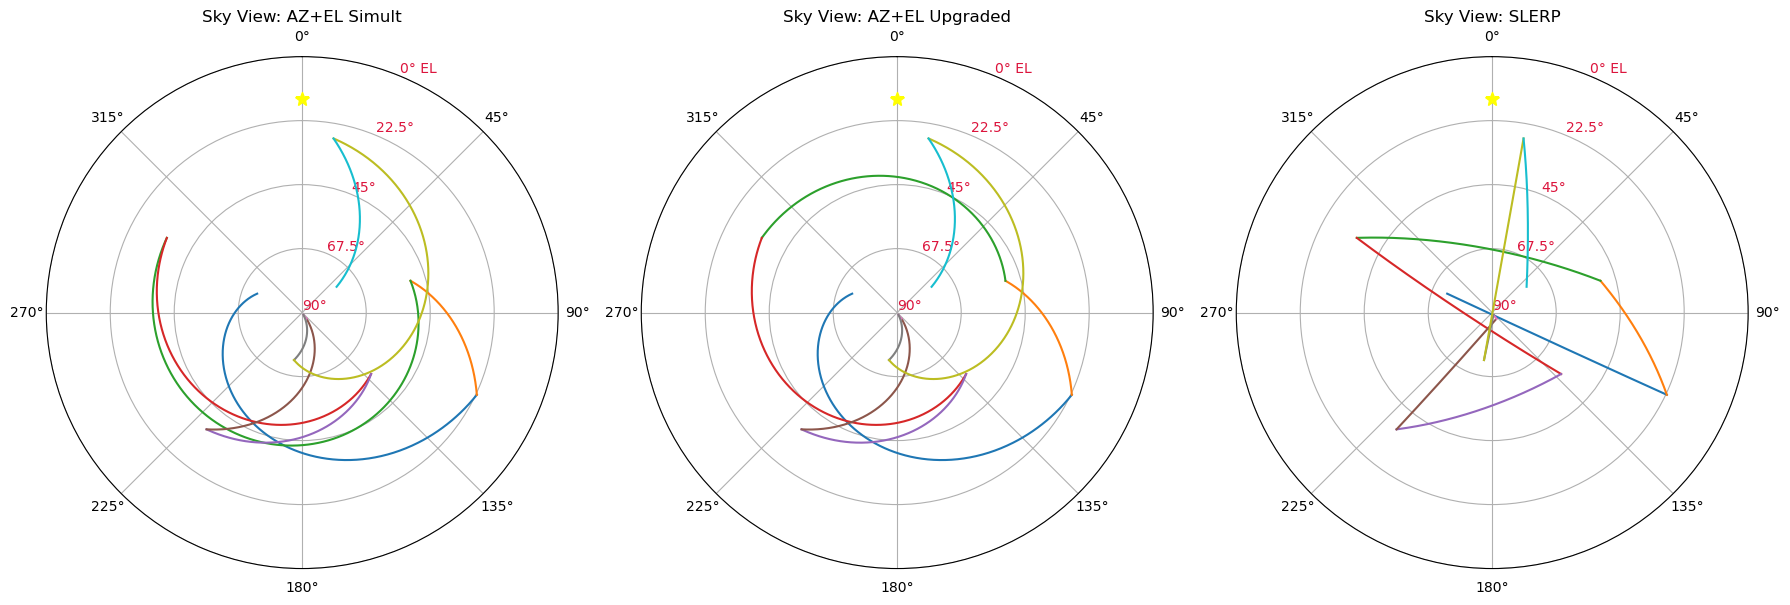

In [470]:
wpts = random_waypoints(n=11)
all_paths4 = calc_paths(waypoints=wpts)
polar_proj(all_paths=all_paths4, legend=False)